<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/LyingTime_MonthsInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for lying time MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

## Data loading into dataframe

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=LyingTimeMinutesPerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-26.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LyingTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-25.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=LyingTimeMinutesPerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-26.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, -1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 917              2514           3+     2            Spring        22   
2 1010             2514           2      2            Summer        22   
3 1027             2514           1      8            Summer        23   
4 900              2514           2      8            Summer        23   
5 10               3              3+     9            Winter        22   
6 920              2514           3+     -1           Summer        22   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [49,867 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1046 levels "1","2","3","4",..: 368 396 411 353 10 371 401 214 166 230 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 3 3 3 3 5 3 3 3 5 3 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 3 2 1 2 3 3 2 3 3 3 ...
 $ MonthsInMilk    : Factor w/ 12 levels "-1","0","1","2",..: 4 4 10 10 11 1 9 4 4 9 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 2 3 3 3 4 3 2 1 1 3 ...
 $ Hour            : Factor w/ 2 levels "22","23": 1 1 2 2 1 1 1 2 2 2 ...
 $ SensorValue     : num [1:49867] 597 800 711 698 680 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 1 1 1 1 2 1 1 1 2 1 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  696
2 2                  690
3 3+                 739


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1046


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )



## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 647751 647777 -323872   647745                         
Model1.0   14 644469 644592 -322220   644441 3303.8 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 647751 647777 -323872   647745                         
Model1.1    5 647739 647783 -323864   647729 15.819  2  0.0003673 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
Model.0     3 647751 647777 -323872   647745                     
Model1.2    6 647751 647804 -323869   647739 5.8771  3     0.1177


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 647751 647777 -323872   647745                         
Model1.3    4 647694 647729 -323843   647686 58.375  1  2.166e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
    (1 | HerdIdentifier:AnimalIdentifier)
              npar    AIC    LRT   Pr(Chi)    
<none>             644375                     
Parity           2 644411   39.7 2.429e-09 ***
MonthsInMilk    11 647681 3328.3 < 2.2e-16 ***
CalvingSeason    3 644384   14.6  0.002207 ** 
MilkingType      1 644428   54.6 1.502e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + CalvingSeason + MilkingType + 
Model2.1:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 644375 644551 -322168   644335                         
Model2.1   42 643960 644330 -321938   643876 459.05 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + CalvingSeason + Parity +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + CalvingSeason + Parity + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 644375 644551 -322168   644335                         
Model2.2   31 644359 644632 -322148   644297 38.557 11  6.298e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + MilkingType + 
Model2.3:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 644375 644551 -322168   644335                         
Model2.3   53 643314 643782 -321604   643208 1126.8 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.4:     MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 644375 644551 -322168   644335                         
Model2.4   86 642848 643606 -321338   642676 1659.5 66  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 642847.7  643606.0 -321337.8  642675.7     49781 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-10.580  -0.347   0.018   0.361  48.749 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept) 11012    104.9   
 Residual                                    21197    145.6   
Number of obs: 49867, groups:  HerdIdentifier:AnimalIdentifier, 1682

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                         776.937      9.663  80.404
MonthsInMilk0                       -88.209     10.669  -8.268
MonthsInMilk1                      -141.843     10.958 -12.944
MonthsInMilk2        

R[write to console]: 
Correlation matrix not shown by default, as p = 84 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
finalModel <- Model2.4
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
                           npar    AIC     LRT Pr(Chi)    
<none>                          642848                    
MonthsInMilk:CalvingSeason   33 643949 1167.82 < 2e-16 ***
MonthsInMilk:Parity          22 643303  498.92 < 2e-16 ***
MonthsInMilk:MilkingType     11 642847   21.67 0.02702 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodellyingtime.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                              Chisq Df Pr(>Chisq)    
MonthsInMilk               3570.568 11  < 2.2e-16 ***
CalvingSeason                15.807  3   0.001242 ** 
Parity                       30.701  2  2.154e-07 ***
MilkingType                  45.871  1  1.263e-11 ***
MonthsInMilk:CalvingSeason 1182.106 33  < 2.2e-16 ***
MonthsInMilk:Parity         501.609 22  < 2.2e-16 ***
MonthsInMilk:MilkingType     21.682 11   0.026959 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 1               627 3.92 Inf       616       638  a       
 2               638 3.88 Inf       627       649  a       
 3               655 3.85 Inf       644       666   b      
 4               674 3.84 Inf       663       685    c     
 5               685 3.84 Inf       674       696    cd    
 6               695 3.83 Inf       684       706     de   
 7               699 3.83 Inf       688       710      e   
 8               701 3.82 Inf       690       712      e   
 9               704 3.84 Inf       693       715      ef  
 10              713 3.84 Inf       702       724       f  
 0               742 3.81 Inf       731       753        g 
 -1              773 4.11 Inf       761       785         h

Results are averaged over the levels of: CalvingSeason, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: 

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 3+        685 3.07 Inf       678       692  a    
 2         695 3.16 Inf       688       703   b   
 1         697 3.22 Inf       689       704   b   

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Spring           687 3.46 Inf       679       696  a    
 Winter           690 3.47 Inf       681       698  a    
 Autumn           692 3.33 Inf       684       701  a    
 Summer           700 3.33 Inf       692       708   b   

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MilkingType lsmean   SE  df asymp.LCL asymp.UCL .group
 CMS            673 3.25 Inf       665       680  a    
 AMS            712 4.85 Inf       701       723   b   

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, Parity 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 


## Interactions

### MonthsInMilk by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 1               598 5.90 Inf       581       615  a      
 2               654 5.70 Inf       638       670   b     
 3               676 5.60 Inf       660       692   bc    
 0               690 5.70 Inf       674       706    cd   
 4               694 5.54 Inf       678       710    cde  
 5               701 5.47 Inf       685       716     de  
 8               707 5.39 Inf       691       722     de  
 9               707 5.38 Inf       692       723     de  
 6               709 5.49 Inf       694       725     de  
 7               710 5.44 Inf       694       725     de  
 10              713 5.33 Inf       698       728      e  
 -1              802 6.98 Inf       782       822       f 

Parity = 2:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 2               637 5.39 Inf       622       653  a      
 1               643 5.45 Inf       627       658  a      
 3               653 5.39 Inf  

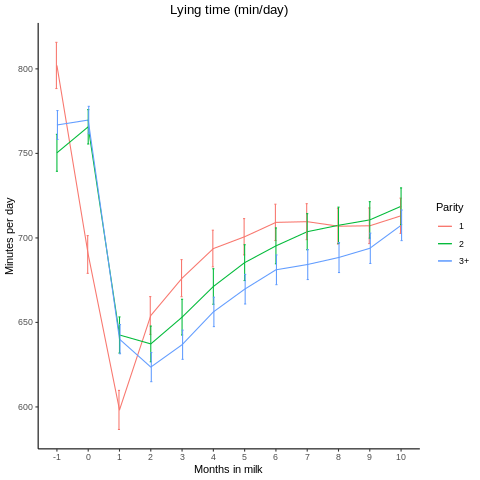

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 1               652 6.44 Inf       633       670  a       
 2               662 6.36 Inf       644       680  ab      
 3               677 6.30 Inf       659       695   bc     
 4               692 6.27 Inf       674       710    cd    
 5               709 6.27 Inf       691       727     de   
 6               716 6.28 Inf       698       734      ef  
 8               718 6.26 Inf       700       736      ef  
 7               718 6.28 Inf       700       736      ef  
 9               721 6.27 Inf       703       739      ef  
 10              733 6.27 Inf       715       751       f  
 0               760 6.24 Inf       742       778        g 
 -1              786 6.59 Inf       767       804         h

MilkingType = CMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 1               602 4.23 Inf       590       614  a       
 2               614 4.21 Inf       602       626  a       
 

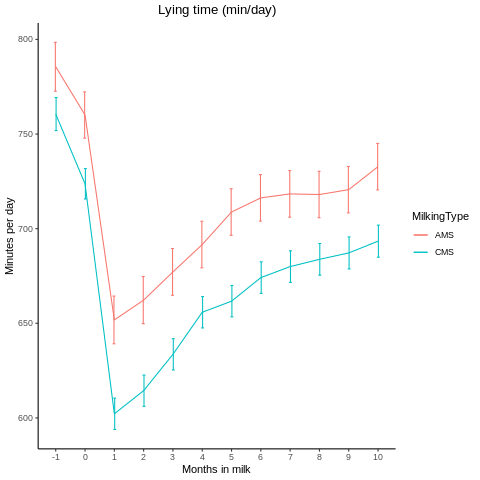

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 49867' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 49867' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 49867)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 1               639 5.15 Inf       624       654  a       
 2               662 5.12 Inf       647       676   b      
 3               682 5.69 Inf       666       698   bc     
 9               682 5.80 Inf       665       699   bc     
 10              685 5.70 Inf       669       701    c     
 4               693 5.69 Inf       677       709    cd    
 8               694 5.83 Inf       677       711    cd    
 5               700 5.29 Inf       685       715    cd    
 6               707 5.36 Inf       692       722     de   
 7               707 5.34 Inf       692       722     de   
 0               722 4.89 Inf       708       736      ef  
 -1              735 5.66 Inf       719       752       f  

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 2               615 6.44 Inf       596       633  a       
 3               618 6.25 Inf       600       636  

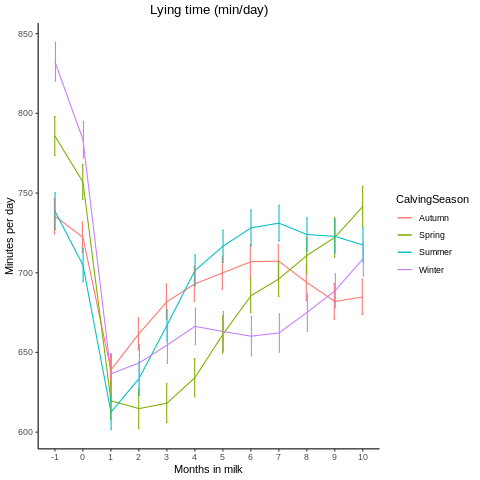

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))